# FINK API Demo

We will see here how to retrieve alerts from SSO from
[FINK](https://ztf.fink-portal.org/), using its
[API](https://api.ztf.fink-portal.org/).

Refer to the [API documentation](https://doc.ztf.fink-broker.org/en/latest/services/search/cheatsheet/) for a full description.

In [1]:
import io
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

**NB:** We use here the ZTF data as demo (LSST alerts are not been released yet), so all URLs contains `ztf.fink`, that must be changed into `lsst.fink` to use Vera C. Ruben LSST alert stream. 

In [29]:
base_url = "https://api.ztf.fink-portal.org/"

# API end-points
url_sso = f"{base_url}api/v1/sso"
url_ssoft = f"{base_url}api/v1/ssoft"

In [3]:
# Define a simple ephemerides query
def ephemcc(ident, ep, nbd=None, step=None, observer="500", rplane="1", tcoor=5):
    """Gets asteroid ephemerides from LTE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    """

    # ------
    # Miriade URL
    url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php"

    # Query parameters
    params = {
        "-name": f"{ident}",
        "-mime": "json",
        "-rplane": rplane,
        "-tcoor": tcoor,
        "-output": "--jd",
        "-observer": observer,
        "-tscale": "UTC",
    }

    # Single epoch of computation
    if type(ep) != list:
        # Set parameters
        params["-ep"] = ep
        if nbd != None:
            params["-nbd"] = nbd
        if step != None:
            params["-step"] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False

    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {"epochs": ("epochs", "\n".join(["%.6f" % epoch for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=50)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j["data"])
    except KeyError:
        return False

    return ephem


## Getting alerts for a given SSO

In [ ]:
my_target = 8467

# Request data
r = requests.post(url_sso, json={"n_or_d": my_target, "output-format": "json"})

# Format output in a DataFrame
df = pd.read_json(io.BytesIO(r.content))

In [5]:
long_ephem = True

In [6]:
# Get a long time-serie of ephemerides
if long_ephem:
    eph = ephemcc(my_target, ep=df["i:jd"].min(), step="5d", nbd=500)

Text(0.5, 1.0, 'SSO 8467')

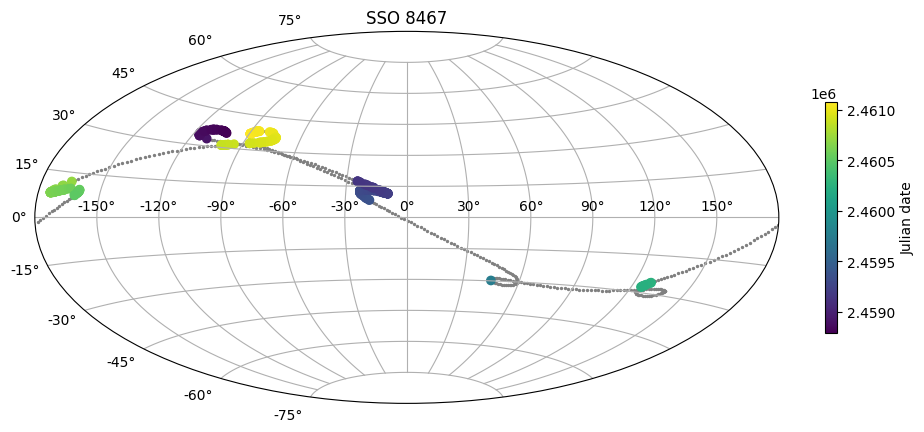

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "aitoff"}, figsize=(12, 6))

# Plot the long ephemerides
if long_ephem:
    ax.scatter(np.radians(eph["RA"]) - np.pi, np.radians(eph["DEC"]), color="grey", s=2)

# Plot the FINK alert data
im = ax.scatter(np.radians(df["i:ra"]) - np.pi, np.radians(df["i:dec"]), c=df["i:jd"])

# Axes
ax.grid()
fig.colorbar(im, ax=ax, label="Julian date", shrink=0.5)
ax.set_title(f"SSO {my_target}")

Text(0.5, 1.0, 'SSO 8467')

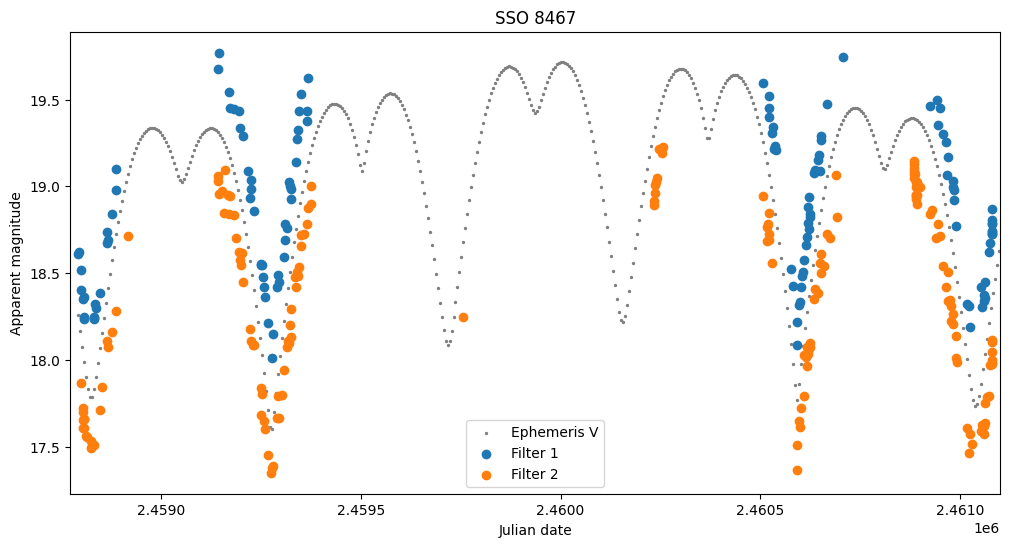

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the long ephemerides
if long_ephem:
    ax.scatter(eph["Date"], eph["VMag"], color="grey", s=2, label="Ephemeris V")

# Plot the FINK alert data
for f in df["i:fid"].unique():
    cond = df["i:fid"] == f
    ax.scatter(df.loc[cond, "i:jd"], df.loc[cond, "i:magpsf"], label=f"Filter {f}")

# Axes
ax.set_xlabel("Julian date")
ax.set_ylabel("Apparent magnitude")
ax.set_xlim(df["i:jd"].min() - 20, df["i:jd"].max() + 20)
ax.legend(loc="lower center")
ax.set_title(f"SSO {my_target}")

Here we cannot plot the observations as function of phase, yet, as we need to compute the ephemerides for the observing time.
It could be done with the provided `ephemcc` function, but [FINK SSO API](https://doc.ztf.fink-broker.org/en/latest/services/search/solar_system/) offers to compute the ephemerides upon request, by adding the `withEphem` to the payload:
 

In [9]:
my_target = "Benoitcarry"

# Request data
r = requests.post(
    url_sso, json={"n_or_d": my_target, "withEphem": True, "output-format": "json"}
)

# Format output in a DataFrame
df = pd.read_json(io.BytesIO(r.content))

In [10]:
eph

,Date,RA,DEC,Dobs,Dhelio,VMag,Phase,Elong.,dRAcosDEC,dDEC,RV
0,2.458792e+06,77.294062,36.161355,2.252635,3.078710,18.258903,11.965669,139.943930,-0.264336,0.148560,-14.929673
1,2.458797e+06,76.558108,36.439451,2.212236,3.076710,18.167019,10.637785,145.015525,-0.327859,0.128888,-13.023924
2,2.458802e+06,75.669166,36.674352,2.177564,3.074741,18.075162,9.247093,150.041532,-0.384966,0.105370,-10.964499
3,2.458807e+06,74.645124,36.858462,2.149050,3.072804,17.985151,7.842286,154.899039,-0.433794,0.078143,-8.760163
4,2.458812e+06,73.509599,36.984796,2.127102,3.070898,17.900604,6.507344,159.361236,-0.471965,0.047734,-6.419315
...,...,...,...,...,...,...,...,...,...,...,...
495,2.461267e+06,145.322859,19.300048,4.049991,3.042413,18.998912,1.711088,5.145100,0.885971,-0.359682,0.238381
496,2.461272e+06,147.192908,18.575651,4.048928,3.043794,19.016106,1.929291,5.811244,0.882688,-0.364610,-0.973005
497,2.461277e+06,149.047275,17.841991,4.044379,3.045215,19.056816,2.519974,7.610177,0.878689,-0.368955,-2.176388
498,2.461282e+06,150.884998,17.100176,4.036364,3.046677,19.102911,3.285803,9.957190,0.874149,-0.372772,-3.374470


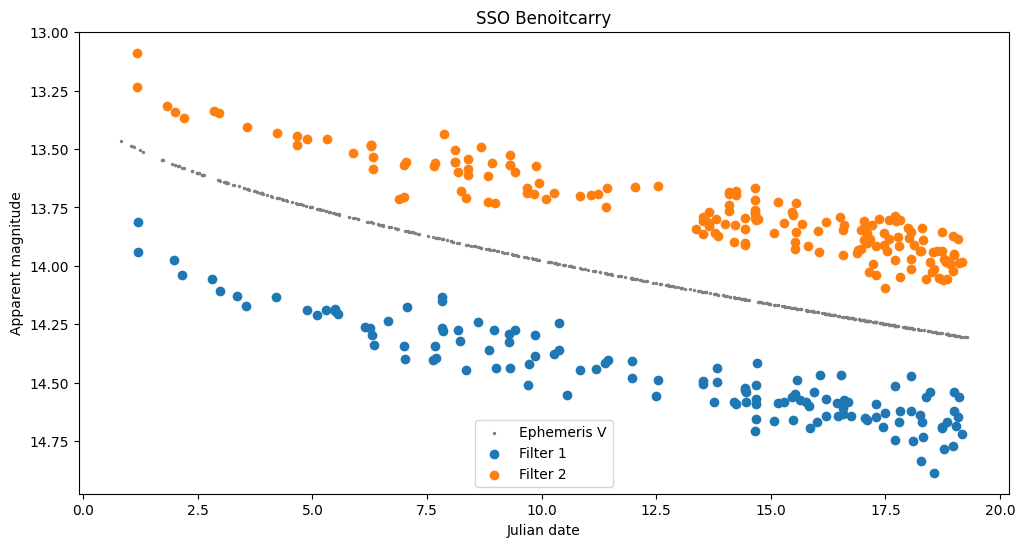

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the long ephemerides
if long_ephem:
    dist_correction = 5 * np.log10(eph.Dobs * eph.Dhelio)
    ax.scatter(
        eph["Phase"],
        eph["VMag"] - dist_correction,
        color="grey",
        s=2,
        label="Ephemeris V",
    )

# Plot the FINK alert data
for f in df["i:fid"].unique():
    cond = df["i:fid"] == f

    dist_correction = 5 * np.log10(df.loc[cond, "Dobs"] * df.loc[cond, "Dhelio"])
    ax.scatter(
        df.loc[cond, "Phase"],
        df.loc[cond, "i:magpsf"] - dist_correction,
        label=f"Filter {f}",
    )

# Axes
ax.set_xlabel("Julian date")
ax.set_ylabel("Apparent magnitude")
ax.legend(loc="lower center")
ax.set_title(f"SSO {my_target}")
ax.yaxis.set_inverted(True)

The offsets between the three bands is simply due to the colors of the target.

## Retrieving cutouts

If you are interested in the small cutouts around each detection, the [FINK SSO API](https://doc.ztf.fink-broker.org/en/latest/services/search/solar_system/) offers thn, by adding the `withcutouts` to the payload.

**NB:** Requests with cutouts are much larger and thus slower. Only request cutouts if you will use them.
 

In [55]:
my_target = "11814"

# Request data
r = requests.post(
    url_sso,
    json={
        "n_or_d": my_target,
        "withcutouts": True,
        "output-format": "json",
    },
    timeout=200,
)


In [62]:
alert = r.json()

print(f"{len(alert)} alerts with cutouts received for SSO {my_target}")

149 alerts with cutouts received for SSO 11814


Text(0, 0.5, 'Y')

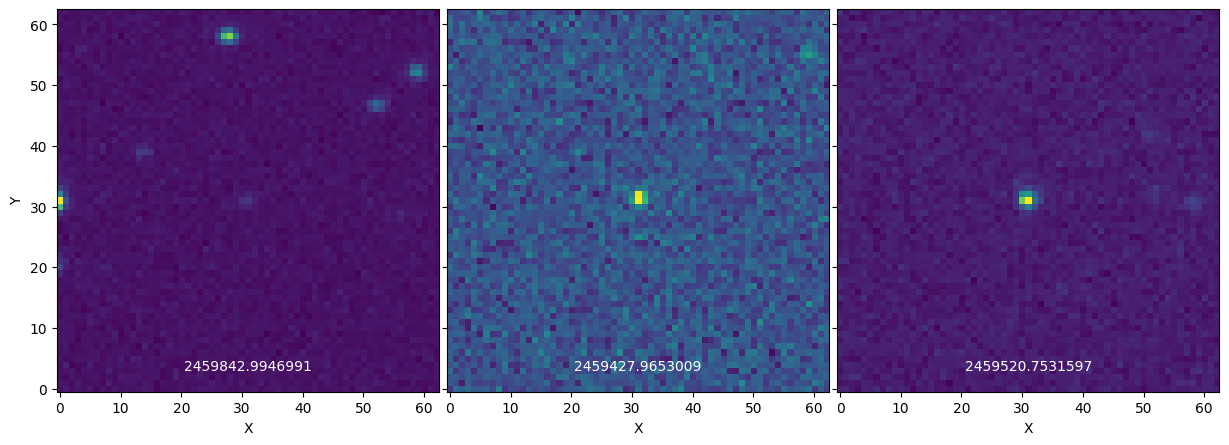

In [90]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True, gridspec_kw={'wspace':0.02})

# Dirty selection of three random images 
i = 0
for test in range(len(alert)):

    if i>=3:
        break

    random_index = int(np.random.uniform() * len(alert))

    try:
        ax[i].imshow( np.array(alert[random_index]["b:cutoutScience_stampData"]), origin='lower' )
        ax[i].text( 31, 3, alert[random_index]['i:jd'], ha='center', color='white')
        ax[i].set_xlabel('X')
        i = i +1

    except:
        continue

ax[0].set_ylabel('Y')

By default, only the `science` cutouts are downloaded, use `cutout-kind` in the payload (see [FINK SSO API documentation](https://doc.ztf.fink-broker.org/en/latest/services/search/solar_system/)) if you want to download the `Template` or the `Difference`.

## Retrieving SSO parameters computed by FINK

Monthly, we compute several phase function models at [FINK](https://ztf.fink-portal.org/):

- `HG` ([Bowell+1989](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B/abstract))
- `HG1G2` ([Muinonen+2010](https://ui.adsabs.harvard.edu/#abs/2010Icar..209..542M/abstract))
- `sHG1G2` ([Carry+2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...687A..38C/abstract))

The results of the fit are provided in a large table with all SSOs, the [SSOFT](https://doc.ztf.fink-broker.org/en/latest/services/search/solar_system/#ssoft-solar-system-object-fink-table), that can be easily downloaded:

In [30]:
# Request SSOFT
r = requests.post(url_ssoft, json={"output-format": "parquet"})

# Format output in a DataFrame
ssoft = pd.read_parquet(io.BytesIO(r.content))

It is a rather larger table: over 150,000 SSOs for 50+ columns
(_at the time of writing: February 2026_)

In [32]:
ssoft

,ssnamenr,chi2red,min_cos_lambda,mean_cos_lambda,max_cos_lambda,status,fit,rms,rms_1,rms_2,...,n_days_1,n_days_2,last_jd,sso_name,sso_number,obliquity,alpha0_alt,delta0_alt,version,flag
0,100806,0.547751,-0.639686,-0.309904,-0.147392,2.0,0.0,0.078480,0.083357,0.074185,...,1633.761597,2018.996582,2461066.00,1998 FD107,100806.0,145.679993,180.000000,89.980644,202602,0
1,168773,0.737198,-0.747408,-0.582584,0.692970,2.0,0.0,0.077770,0.062277,0.087848,...,2150.033447,2179.000732,2460968.75,2000 RA22,168773.0,134.281715,331.721558,40.194057,202602,0
2,159780,1.759968,-0.438412,0.032477,0.632182,2.0,0.0,0.081205,0.096073,0.067666,...,1499.791016,1544.745605,2460910.75,2003 MV6,159780.0,32.933077,68.536331,-50.190956,202602,0
3,120884,1.467909,-0.385270,-0.227692,0.356936,2.0,0.0,0.137290,0.139459,0.135906,...,1937.699707,1981.658203,2461028.50,1998 RY50,120884.0,160.061446,299.104446,70.962082,202602,0
4,71951,0.646416,-0.373663,0.213316,0.418051,2.0,0.0,0.083329,0.075775,0.087734,...,1629.777466,1986.045166,2461029.00,2000 WY99,71951.0,24.980600,180.000000,-83.153008,202602,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175964,39123,3.180160,-0.231518,-0.042790,0.265625,2.0,0.0,0.158286,0.146779,0.165700,...,2025.740356,2035.833252,2460992.75,2000 WR42,39123.0,14.201080,67.582886,-59.646065,202602,0
175965,64194,2.224955,-0.372368,-0.042748,0.288679,2.0,0.0,0.138220,0.126821,0.145495,...,2175.621582,2206.689209,2461059.75,2001 TD72,64194.0,158.229934,337.768738,65.163376,202602,0
175966,86369,2.963976,-0.195755,0.012811,0.188191,2.0,0.0,0.167060,0.178993,0.159273,...,2095.049316,2110.074707,2460899.75,1999 XK226,86369.0,13.949010,69.454697,-51.010944,202602,0
175967,61768,11.169543,-0.684182,-0.085653,0.611830,4.0,0.0,0.304171,0.283183,0.316447,...,1952.954712,2061.689453,2461059.75,2000 QK168,61768.0,134.404174,295.177544,29.364849,202602,0


Text(0, 0.5, 'G2')

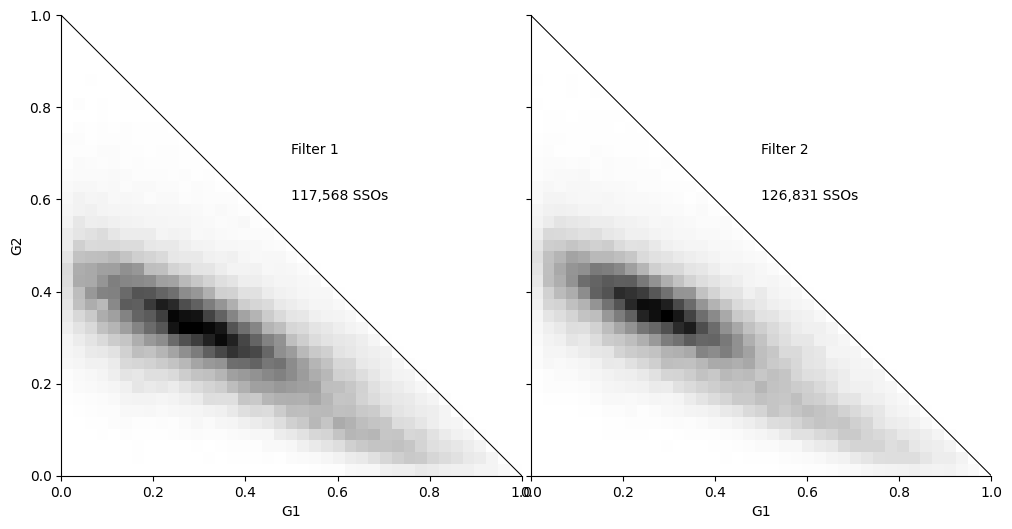

In [49]:
fig, ax = plt.subplots(
    1, 2, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw={"wspace": 0.02}
)

bins = np.linspace(0, 1, num=40)
for i, f in enumerate([1, 2]):
    # Plot valid data (fullfilling G1G2 prescriptions from Muinonen+2010)
    threshold = 0.01
    cond = (
        (threshold < ssoft[f"G1_{f}"])
        & (threshold < ssoft[f"G2_{f}"])
        & (1 - ssoft[f"G1_{f}"] - ssoft[f"G2_{f}"] > threshold)
    )
    ax[i].hist2d(
        ssoft.loc[cond, f"G1_{f}"],
        ssoft.loc[cond, f"G2_{f}"],
        bins=[bins, bins],
        cmap="Greys",
    )
    ax[i].text( 0.5,0.7, f"Filter {f}")
    ax[i].text( 0.5,0.6, f"{cond.sum():,d} SSOs")

    # Axes
    ax[i].set_aspect("equal")
    ax[i].set_xlabel("G1")
    ax[i].plot([0, 1], [1, 0], linewidth=0.75, color="black")
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

ax[0].set_ylabel("G2")


Text(0.5, 0, 'g-r')

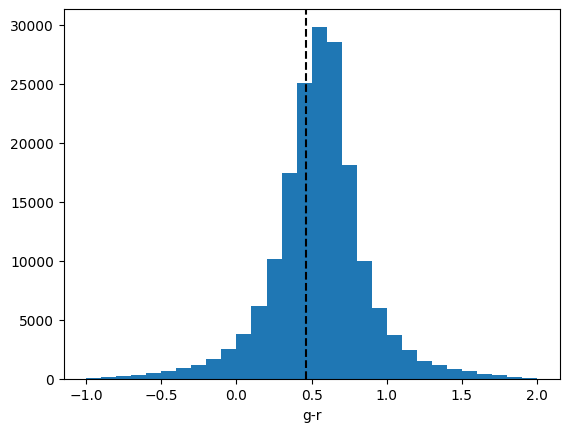

In [ ]:
fig, ax = plt.subplots()

# Create a strict condition with all G1G2 in all filters to be valid
cond = ssoft.index==ssoft.index
for i, f in enumerate([1, 2]):
    threshold = 0.01
    cond = cond & (
        (threshold < ssoft[f"G1_{f}"])
        & (threshold < ssoft[f"G2_{f}"])
        & (1 - ssoft[f"G1_{f}"] - ssoft[f"G2_{f}"] > threshold)
    )

# Color histogram (ZTF g-r)
bins = np.linspace(-1,2,num=31)
ax.hist( ssoft[f"H_1"]-ssoft[f"H_2"], bins=bins, label='SSOFT' )

ax.axvline( 0.46, linestyle='--', color='black', label='Solar color')

ax.set_xlabel('g-r')

The $g-$ colors derived from the absolute magnitude in each filter (thanks to the phase function model) match the expected solar color of 0.46 (AB photometry).

The solar color was obtained from [SKA](https://space-ska.readthedocs.io/en/latest/):
```
$ pip install space-ska
[...]

$ ska solarcolor Palomar/ZTF.g Palomar/ZTF.r --phot_sys AB
0.46
```